# Model

#### Preparation

In [1]:
!pip list | grep torch
%cd /content/drive/MyDrive/ 
%ls
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html #colab会更新torch和cuda版本，对应mmcv版本也要及时更新

torch                         1.10.0+cu111
torchaudio                    0.10.0+cu111
torchsummary                  1.5.1
torchtext                     0.11.0
torchvision                   0.11.1+cu111
/content/drive/MyDrive
 cimg.rar            img.rar         Iono4311v2/   mmsegmentation/
 cmask.rar           Iono2630_npy@   label.rar     mmsegmentation17/
'Colab Notebooks'/   Iono4311.rar    mmp/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
     |████████████████████████████████| 46.0 MB 8.7 MB/s 
     |████████████████████████████████| 190 kB 5.3 MB/s 


In [2]:
%cd mmsegmentation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
import mmseg
print(mmseg.__version__)
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette
import mmcv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os.path as osp
import numpy as np
from PIL import Image
import time

/content/drive/MyDrive/mmsegmentation
1.10.0+cu111 True
0.20.2


#### Dataset Setting

In [ ]:
data_root = 'Iono4311'
img_dir = 'cimg'
ann_dir = 'cmask'
split_dir = 'splits'
label_dir = 'label'
classes = ('Background', 'E', 'Es-l', 'Es-c', 'F1', 'F2', 'Spread F')
palette = [[230, 230, 230], [250, 165, 30], [120, 69, 125], [53, 125, 34], 
           [0, 11, 123], [130, 20, 12], [120, 121, 80]]
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
# 定义数据集类型，指定类名称，调色板，后缀等 打开你文件后第二次执行需要注释以下内容

@DATASETS.register_module()
class StandfordBackgroundDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

#### Load Trained Model


In [6]:
from mmcv import Config
cfg = Config.fromfile('./work_dirs/ckpt/pspnet_ce.py')
model_path = './work_dirs/ckpt/' + 'iou_3922_acc_9153' + '.pth'

# initialize segmentor
model = init_segmentor(cfg,  model_path, device='cuda:0') 

load checkpoint from local path: ./work_dirs/ckpt/iou_3922_acc_9153.pth


#### Inference

/content/drive/MyDrive/mmsegmentation/mmseg/models/segmentors/base.py:284: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


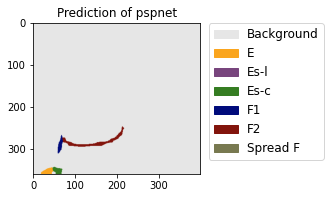

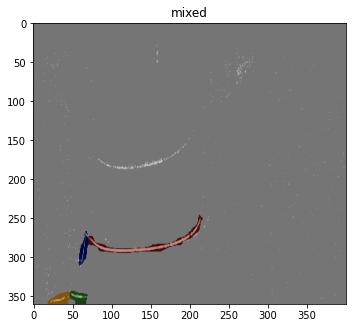

In [7]:
# test a single image
img = mmcv.imread('Iono4311/cimg/20191106131500.png')
result = inference_segmentor(model, img)

# show result
plt.figure(figsize=(3,3))
plt.title('Prediction of pspnet')
seg_res = Image.fromarray(np.uint8(result[0])).convert('P')
seg_res.putpalette(np.array(palette, dtype=np.uint8))
im = plt.imshow(np.array(seg_res.convert('RGB')))
patches = [mpatches.Patch(color=np.array(palette[i])/255.,label=classes[i]) for i in range(7)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize='large')

show_result_pyplot(model, img, result, fig_size=(5,5), title='mixed')

### Functions


```
single_load
post_seg
interpret
show_cha_pyplot
```



#### Load Data

```
[gimg, cimg, label, cmask, seg] = single_load(name)
```
@gimg, grayscale ionogram
@cimg, color ionogram
@seg, inference result
@label, grascale label
@cmask, color mask


In [8]:
import cv2
def single_load(name):
  label = cv2.imread(data_root + '/' + label_dir + '/' + name + '.png', cv2.IMREAD_GRAYSCALE) # 真实标签，gray ndarray
  cmask = Image.open(data_root + '/' + ann_dir + '/' + name + '.png')
  cimg = mmcv.imread(data_root + '/' + img_dir + '/' + name + '.png')  # numpy
  segs = inference_segmentor(model, cimg)
  gimg = cimg[:,:,0]  
  seg = segs[0]        
  return [gimg, cimg, label, cmask, seg]

#### Edge Detection and Feature Fusion 


```
segmap = post_seg(seg, cimg)
```



In [9]:
def post_seg(seg, cimg):
  th1 = 256*2
  th2 = 400
  blurred = cv2.GaussianBlur(cimg, (3, 3), 0)
  edge = cv2.Canny(blurred, 50, 150)
  edge = edge / 255
  # Hadamard product
  segmap = seg * edge
  return segmap

#### Determine e, f1, f2 Parameters
```
[minh, maxf] = character(segmap)
[minh, maxf] = cha_e(segmap)
[minh, maxf] = cha_f1(segmap)
fmin = cha_fmin(segmap)
return [-500,-1000] when traces do not exist
```



In [10]:
def character(segmap):
  minh = -1
  maxf = -1
  list_dh = []
  for i in range(359, -1, -1):
    for j in range(400):
      if (segmap[i,j] == 5) | (segmap[i,j] == 6):
        minh = i
        break
    if minh != -1:
      break

  for j in range(399,-1,-1):
    for i in range(minh, -1, -1):
      if (segmap[i,j] == 5) | (segmap[i,j] == 6):
        maxf = j
        break
    if maxf != -1:
      break
  return [minh, maxf]

def cha_e(segmap):
  minh = -1
  maxf = -1
  list_dh = []
  for i in range(359, -1, -1):
    for j in range(400):
      if (segmap[i,j] == 1):
        minh = i
        break
    if minh != -1:
      break

  for j in range(399,-1,-1):
    for i in range(minh, -1, -1):
      if (segmap[i,j] == 1):
        maxf = j
        break
    if maxf != -1:
      break
  if (minh == -1) | (maxf == -1):
    return[-500, -1000]
  return [minh, maxf]

def cha_f1(segmap):
  minh = -1
  maxf = -1
  list_dh = []
  for i in range(359, -1, -1):
    for j in range(400):
      if (segmap[i,j] == 4):
        minh = i
        break
    if minh != -1:
      break

  for j in range(399,-1,-1):
    for i in range(minh, -1, -1):
      if (segmap[i,j] == 4):
        maxf = j
        break
    if maxf != -1:
      break
  if (minh == -1) | (maxf == -1):
    return[-500, -1000]
  return [minh, maxf]

def cha_fmin(segmap):
  fmin = -1
  for j in range(400):
    for i in range(360):
      if (segmap[i,j] != 0):
        fmin = j
        break
    if fmin != -1:
      break
  return fmin
        

#### Obtain Parameters


```
[mh_pred, mf_pred, mhe_pred, mfe_pred, mhf1_pred, mff1_pred, fmin] = interpret(segmap)
```



In [11]:
def interpret(segmap):
  # f2
  [mh_pred, mf_pred] = character(segmap)
  # e
  [mhe_pred, mfe_pred] = cha_e(segmap)
  # f1
  [mhf1_pred, mff1_pred] = cha_f1(segmap)
  # fmin
  fmin = cha_fmin(segmap)
  return [mh_pred, mf_pred, mhe_pred, mfe_pred, mhf1_pred, mff1_pred, fmin]


#### Visualization


```
show_cha_pyplot(cimg, cmask, segmap, palette,
                            mh_pred, mf_pred, mhe_pred, mfe_pred, mhf1_pred, mff1_pred,
                            mh_truth, mf_truth, mhe_truth, mfe_truth, mhf1_truth, mff1_truth):

```



In [12]:
def show_cha_pyplot(cimg, cmask, segmap, palette,
                                  mh_pred, mf_pred, mhe_pred, mfe_pred, mhf1_pred, mff1_pred, fmin_pred,
                                  mh_truth, mf_truth, mhe_truth, mfe_truth, mhf1_truth, mff1_truth, fmin_truth):
  plt.figure(figsize=(28, 9))
  plt.subplot(131)
  plt.xlabel('Frequency (MHz)')
  plt.ylabel('Virtual Height (km)')
  plt.yticks([0, 40, 80, 120, 160, 200, 240, 280, 320, 360],[990, 890, 790, 690, 590, 490, 390, 290, 190, 90])
  plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400],[1.0, 3.5, 6.0, 8.5, 11.0, 13.5, 16.0, 18.5, 21.0])
  # plt.title('Input Image')
  plt.imshow(cimg)

  plt.subplot(132)
  plt.xlabel('Frequency (MHz)')
  plt.ylabel('Virtual Height (km)')
  plt.yticks([0, 40, 80, 120, 160, 200, 240, 280, 320, 360],[990, 890, 790, 690, 590, 490, 390, 290, 190, 90])
  plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400],[1.0, 3.5, 6.0, 8.5, 11.0, 13.5, 16.0, 18.5, 21.0])
  # plt.title('Ground Truth')
  plt.imshow(cmask)
  # f2
  plt.axvline(mf_truth,color='g',linestyle=":",alpha=0.8) 
  plt.text(mf_truth, -2,'foF2', color = 'g')
  plt.axhline(mh_truth,color='r',linestyle="--",alpha=0.8) 
  plt.text(401, mh_truth-3,'h\'F2', color = 'r')
  # E
  if mfe_truth > 0:
    plt.axvline(mfe_truth,color='g',linestyle=":",alpha=0.8) 
    plt.text(mfe_truth-6, -2,'foE', color = 'g')
    plt.axhline(mhe_truth,color='r',linestyle="--",alpha=0.8)
    plt.text(401, mhe_truth-3,'h\'E', color = 'r')
  # f1
  if mff1_truth > 0:
    plt.axvline(mff1_truth,color='g',linestyle=":",alpha=0.8) 
    plt.text(mff1_truth, -2,'foF1', color = 'g')
    plt.axhline(mhf1_truth,color='r',linestyle="--",alpha=0.8)  
    plt.text(401, mhf1_truth-3,'h\'F1', color = 'r')
  if fmin_pred > 0:
    plt.axvline(fmin_truth,color='g',linestyle=":",alpha=0.8) 
    plt.text(fmin_truth-18, -2,'fmin', color = 'g')

  plt.subplot(133)
  plt.xlabel('Frequency (MHz)')
  plt.ylabel('Virtual Height (km)')
  plt.yticks([0, 40, 80, 120, 160, 200, 240, 280, 320, 360],[990, 890, 790, 690, 590, 490, 390, 290, 190, 90])
  plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400],[1.0, 3.5, 6.0, 8.5, 11.0, 13.5, 16.0, 18.5, 21.0])
  # plt.title('Final Prediction')
  seg_res = Image.fromarray(np.uint8(segmap)).convert('P')
  seg_res.putpalette(np.array(palette, dtype=np.uint8))
  im = plt.imshow(np.array(seg_res.convert('RGB')))
  plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize='large')
  # f2
  plt.axvline(mf_pred,color='g',linestyle=":",alpha=0.8) 
  plt.text(mf_pred, -2,'foF2', color = 'g')
  plt.axhline(mh_pred,color='r',linestyle="--",alpha=0.8) 
  plt.text(401, mh_pred-3,'h\'F2', color = 'r')
  # E
  if mfe_pred > 0:
    plt.axvline(mfe_pred,color='g',linestyle=":",alpha=0.8) 
    plt.text(mfe_pred-6, -2,'foE', color = 'g')
    plt.axhline(mhe_pred,color='r',linestyle="--",alpha=0.8) 
    plt.text(401, mhe_pred-3,'h\'E', color = 'r')
  # f1
  if mff1_pred > 0:
    plt.axvline(mff1_pred,color='g',linestyle=":",alpha=0.8) 
    plt.text(mff1_pred, -2,'foF1', color = 'g')
    plt.axhline(mhf1_pred,color='r',linestyle="--",alpha=0.8) 
    plt.text(401, mhf1_pred-3,'h\'F1', color = 'r')
  if fmin_pred > 0:
    plt.axvline(fmin_pred,color='g',linestyle=":",alpha=0.8) 
    plt.text(fmin_pred-18, -2,'fmin', color = 'g')
  # save as png
  plt.savefig('results/'+str(cnt)+'.png')
  plt.show()

#### Overview of the Model

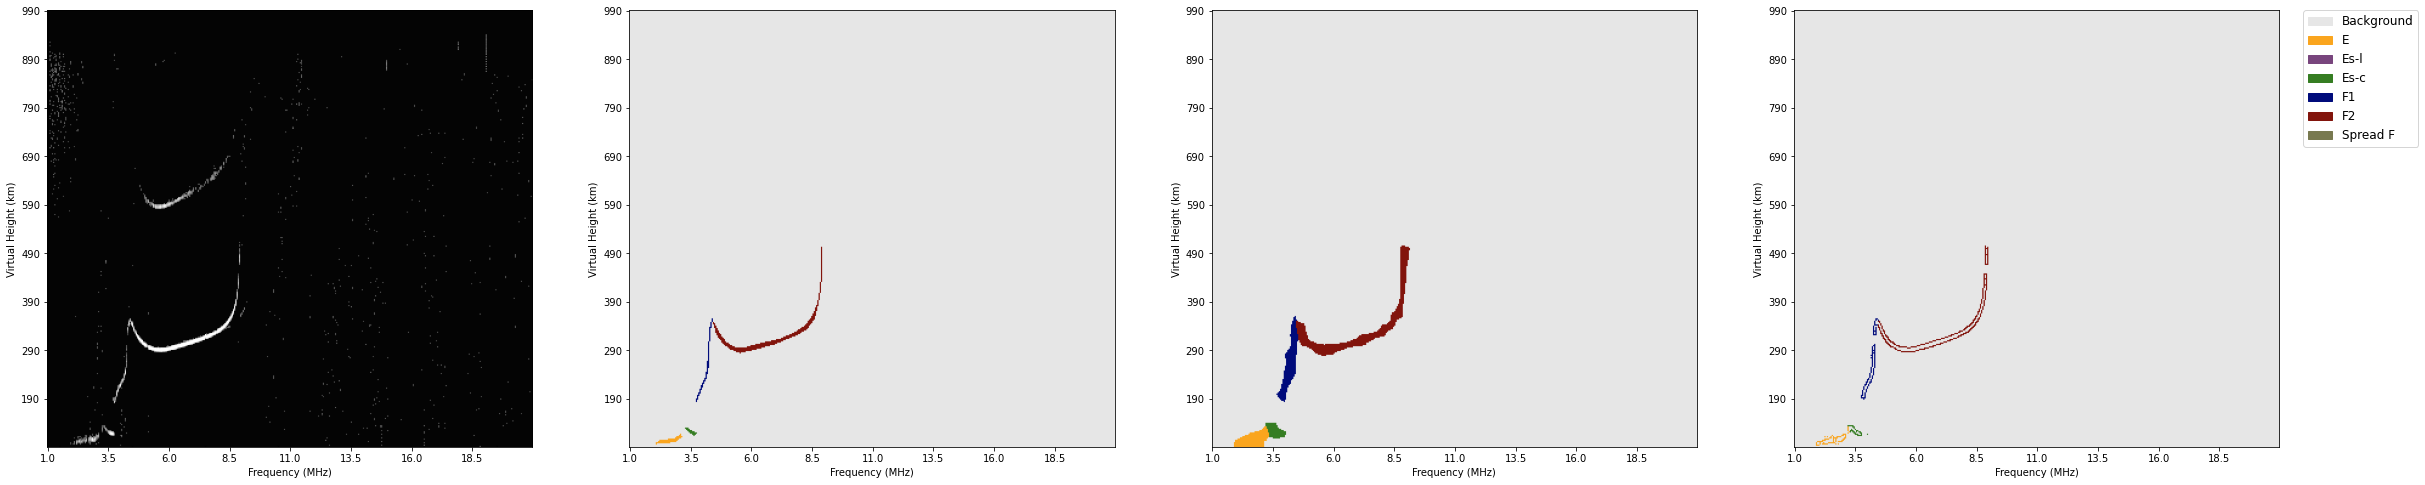

In [14]:
import sys
name_list=[]
with open("/content/drive/MyDrive/mmsegmentation/Iono4311/splits/val.txt", "r") as f:  # 打开文件
	for line in f:
		name_list.append(''.join(line.strip('\n').split(',')))

name = name_list[780]
[gimg, cimg, label, cmask, seg] = single_load(name)

blurred = cv2.GaussianBlur(cimg, (3, 3), 0)
edge = cv2.Canny(blurred, 50, 150)
edge = 1 - edge / 255
# 与seg取交集
segmap = seg * edge
segmap = post_seg(seg, cimg)

plt.figure(figsize=(40, 9))
plt.subplot(141)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Virtual Height (km)')
plt.yticks([0, 40, 80, 120, 160, 200, 240, 280, 320, 360],[990, 890, 790, 690, 590, 490, 390, 290, 190, 90])
plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400],[1.0, 3.5, 6.0, 8.5, 11.0, 13.5, 16.0, 18.5, 21.0])
# plt.title('Input Ionogram')
plt.imshow(cimg)
plt.subplot(142)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Virtual Height (km)')
plt.yticks([0, 40, 80, 120, 160, 200, 240, 280, 320, 360],[990, 890, 790, 690, 590, 490, 390, 290, 190, 90])
plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400],[1.0, 3.5, 6.0, 8.5, 11.0, 13.5, 16.0, 18.5, 21.0])
# plt.title('Edges of the trace')
plt.imshow(cmask)
# plt.imshow(edge, cmap='binary')
plt.subplot(143)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Virtual Height (km)')
plt.yticks([0, 40, 80, 120, 160, 200, 240, 280, 320, 360],[990, 890, 790, 690, 590, 490, 390, 290, 190, 90])
plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400],[1.0, 3.5, 6.0, 8.5, 11.0, 13.5, 16.0, 18.5, 21.0])
# plt.title('Prediction of segmentation networks')
seg_res = Image.fromarray(np.uint8(seg)).convert('P')
seg_res.putpalette(np.array(palette, dtype=np.uint8))
im = plt.imshow(np.array(seg_res.convert('RGB')))
patches = [mpatches.Patch(color=np.array(palette[i])/255.,label=classes[i]) for i in range(7)]
plt.subplot(144)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Virtual Height (km)')
plt.yticks([0, 40, 80, 120, 160, 200, 240, 280, 320, 360],[990, 890, 790, 690, 590, 490, 390, 290, 190, 90])
plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400],[1.0, 3.5, 6.0, 8.5, 11.0, 13.5, 16.0, 18.5, 21.0])
# plt.title('Edge of each layer')
seg_res = Image.fromarray(np.uint8(segmap)).convert('P')
seg_res.putpalette(np.array(palette, dtype=np.uint8))
im = plt.imshow(np.array(seg_res.convert('RGB')))
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize='large')
plt.savefig('results/mask.png')
plt.show()


# Evaluate

In [16]:
import sys
name_list=[]
with open("/content/drive/MyDrive/mmsegmentation/Iono4311/splits/val.txt", "r") as f:  # 打开文件
	for line in f:
		name_list.append(''.join(line.strip('\n').split(',')))
N = len(name_list)

In [ ]:
cfg = Config.fromfile('./work_dirs/ckpt/pspnet_ce.py')
model_path = './work_dirs/ckpt/' + 'iou_3589_acc_9352' + '.pth'
model = init_segmentor(cfg,  model_path, device='cuda:0') 

cnt = 0
sample_interval = 1
tic1  = time.perf_counter()

list_pred = []
list_target = []

# for name in name_list:
while cnt < N:
  name = name_list[cnt]
  [gimg, cimg, label, cmask, seg] = single_load(name)
  segmap = post_seg(seg, cimg) 

  [mh_pred, mf_pred, mhe_pred, mfe_pred, mhf1_pred, mff1_pred, fmin_pred] = interpret(segmap)
  [mh_truth, mf_truth, mhe_truth, mfe_truth, mhf1_truth, mff1_truth, fmin_truth] = interpret(label)

  list_pred.append([mh_pred, mf_pred-1, mhe_pred, mfe_pred-1, mhf1_pred, mff1_pred-1, fmin_pred+1])
  list_target.append([mh_truth, mf_truth, mhe_truth, mfe_truth, mhf1_truth, mff1_truth, fmin_truth])
  
  if cnt % 20 == 0:
    tic2  = time.perf_counter()
    print(cnt, '/', N, 'time:', tic2-tic1, 's')

  cnt = cnt + sample_interval

cha_pred = np.array(list_pred)
cha_target = np.array(list_target)
np.save('./work_dirs/npz/pred_3589', cha_pred)
np.save('./work_dirs/npz/target_3589', cha_target)

(1604, 4)
fmin cases 863
dh cases 1604 dfcases 2467
[-135.   -50.   -47.5  -45.   -42.5  -40.   -32.5  -30.   -27.5  -25.
  -22.5  -20.   -17.5  -15.   -12.5  -10.    -7.5   -5.    -2.5    0.
    2.5    5.     7.5   10.    12.5   15.    17.5   20.    30.    37.5
   40.    57.5]
[-2.05 -1.7  -1.6  -1.45 -1.4  -1.3  -1.25 -1.2  -1.15 -1.1  -1.   -0.95
 -0.9  -0.85 -0.8  -0.75 -0.7  -0.65 -0.6  -0.55 -0.5  -0.45 -0.4  -0.35
 -0.3  -0.25 -0.2  -0.15 -0.1  -0.05  0.    0.05  0.1   0.15  0.2   0.25
  0.3   0.35  0.4   0.45  0.7   0.8   1.1   1.55  1.65  1.8   1.95  4.
  5.15]
('dhF2 <= 10km:', 0.9884125144843569)
('dfoF2 <= 0.2MHz:', 0.9721900347624566)
mean absolute DH 2.8849750623441395
mean absolute DF 0.09120389136603162

mean DH -0.9865960099750624
mean DF -0.023186055938386706
mean DFmin -0.0906720741599073


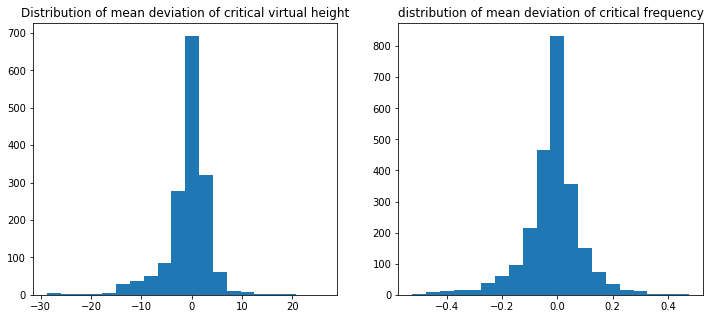

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
cha_pred = np.load('./work_dirs/npz/pred_3589.npy')
cha_target = np.load('./work_dirs/npz/target_3589.npy')
# mh_f2,  mf_f2,  mh_e,  mf_e,  mh_f1, mf_f1
list_dF2 = []

dh = 0
df = 0
list_d = []   #[i, j, dh, df]    @i: image number @j: {0: f2; 2: e; 4: f1; 6:fmin}
list_dfmin = []
cnt = 0
for i in range(N):
  for j in [0,2,4]:
    if ((cha_pred[i][j] != -500) & (cha_target[i][j] != -500)):    
      if j == 0:
        list_d.append([i, j, (-cha_pred[i][j] + cha_target[i][j]), (cha_pred[i][j+1] - cha_target[i][j+1])])
        list_dF2.append([-cha_pred[i][j] + cha_target[i][j], cha_pred[i][j+1] - cha_target[i][j+1]])
      else:
        list_d.append([i, j, (-cha_pred[i][j] + cha_target[i][j]), (cha_pred[i][j+1] - cha_target[i][j+1])])   # 非F2 的临界频率 -1

dev = np.array(list_d)
print(np.shape(dev))
list_dfmin = []
for i in range(N):
  j = 6
  if ((cha_pred[i][j] != -1) & (cha_target[i][j] != -1)):   
    list_dfmin.append(cha_pred[i][j] - cha_target[i][j])

print('fmin cases', len(list_dfmin))
dfmin = np.array(list_dfmin)
dfmin = 0.05*dfmin    # fmin

list_dF2 = np.array(list_dF2)
dfoF2 = list_dF2[:,1] * 0.05
dhF2 = list_dF2[:,0] * 2.5

dh = 2.5*dev[:,2]
df = 0.05*dev[:,3]
df = np.concatenate((df, dfmin), axis=None)

print('dh cases', len(dh), 'dfcases', len(df))

cnt = 0

print(np.unique(dh))
print(np.unique(df))
for i in range(len(dhF2)):
  if(abs(dhF2[i]) > 10):
    cnt = cnt + 1
print(('dhF2 <= 10km:', 1-cnt/len(dhF2)))
for i in range(len(dfoF2)):
  if(abs(dfoF2[i]) > 0.2):
    cnt = cnt + 1
print(('dfoF2 <= 0.2MHz:', 1-cnt/len(dfoF2)))
print('mean absolute DH', np.mean(abs(dh)))
print('mean absolute DF', np.mean(abs(df)) )
print('\nmean DH', np.mean(dh))
print('mean DF', np.mean(df))
print('mean DFmin', np.mean(dfmin))
# plot hist
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(dh, 20, (-28.75,26.25))
plt.title('Distribution of mean deviation of critical virtual height')

plt.subplot(122)
plt.hist(df, 20, (-0.525, 0.475))
plt.title('distribution of mean deviation of critical frequency')
plt.show()